# Preparation

In [1]:
import scanpy as sc
import numpy as np
import os
import anndata2ri
import pathlib
import scvelo as scv
from scipy import io
import anndata#
import pandas as pd
from tqdm import tqdm
import argparse
import sys
import re
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
# sc.logging.print_versions()

import warnings
warnings.filterwarnings("ignore")

outdir = "/home/hieunguyen/CRC1382/outdir"
PROJECT = "SAlBounny_full"
path_to_loom_data = os.path.join(outdir, PROJECT, "velocyto_output")
output_version = "20241021"

object_name = "SAlBounny_full.filter_contaminated_cells.clusterRes_0.5_subcluster_gene_Izumo1r"

path_to_main_output = os.path.join(outdir, PROJECT, output_version, "data_analysis")
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_02_output = os.path.join(path_to_main_output, "02_output")
path_to_03_output = os.path.join(path_to_main_output, "03_output")
path_to_08_output = os.path.join(path_to_main_output, "08_output")

path_to_seurat2anndata = os.path.join(path_to_08_output, "seurat2anndata")

#####------------------------------------------------------------#####
##### READ LOOM DATA
#####------------------------------------------------------------#####
all_looms = [item for item in pathlib.Path(path_to_loom_data).glob("*.loom")]

velodata_dict = dict()
for input_loom in tqdm(all_looms):
    velodata = scv.read_loom(input_loom)
    if "200709" in input_loom.name:
        samplename = input_loom.name.replace("SAlBounny_200709_", "").replace(".loom", "")
    else:
        samplename = input_loom.name.replace("SAlBounny_", "").replace(".loom", "")

    new_obs = ["{}_{}_{}-1".format(samplename, samplename, item.split(":")[1].replace("x", "")) for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata.obs["barcode"] = new_obs
    velodata.var_names_make_unique()
    pattern = re.compile('_[A|T|G|C]*-')
    new_obs = [samplename + pattern.search(string = item).group() + item.split("-")[1]
              for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata_dict[samplename] = velodata
    velodata.var_names_make_unique()

all_velodata = velodata_dict[list(velodata_dict.keys())[0]]
for data in list(velodata_dict.keys())[1:]:
    all_velodata = all_velodata.concatenate(velodata_dict[data])
    
new_obs = [item.split("-")[0] + "-1" for item in all_velodata.obs.index]
all_velodata.obs.index = new_obs
all_velodata.var_names_make_unique()

#####------------------------------------------------------------#####
##### READ ANNDATA
#####------------------------------------------------------------#####
adata = sc.read_h5ad(os.path.join(path_to_seurat2anndata, '{}.h5ad'.format(object_name)))


100%|██████████| 7/7 [00:38<00:00,  5.49s/it]


# Main analysis

## Pre-processing pipeline, prepare for RNA velocity analysis

In [2]:
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(all_velodata)
merge_data = scv.utils.merge(adata, all_velodata)

scv.pp.filter_genes(merge_data, min_shared_counts=20)
scv.pp.normalize_per_cell(merge_data)
scv.pp.filter_genes_dispersion(merge_data, n_top_genes=2000)
scv.pp.log1p(merge_data)

scv.pp.filter_and_normalize(merge_data, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(merge_data, n_pcs=30, n_neighbors=30)

Filtered out 10937 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 453 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:03)
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## RNA velocity inference

In [3]:
# scv.tl.recover_dynamics(merge_data, n_jobs = 15)
# scv.tl.velocity(merge_data, mode="dynamical", diff_kinetics = True)
scv.tl.velocity(merge_data)
scv.tl.velocity_graph(merge_data)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/28 cores)


  0%|          | 0/10558 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## RNA velocity on UMAP

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


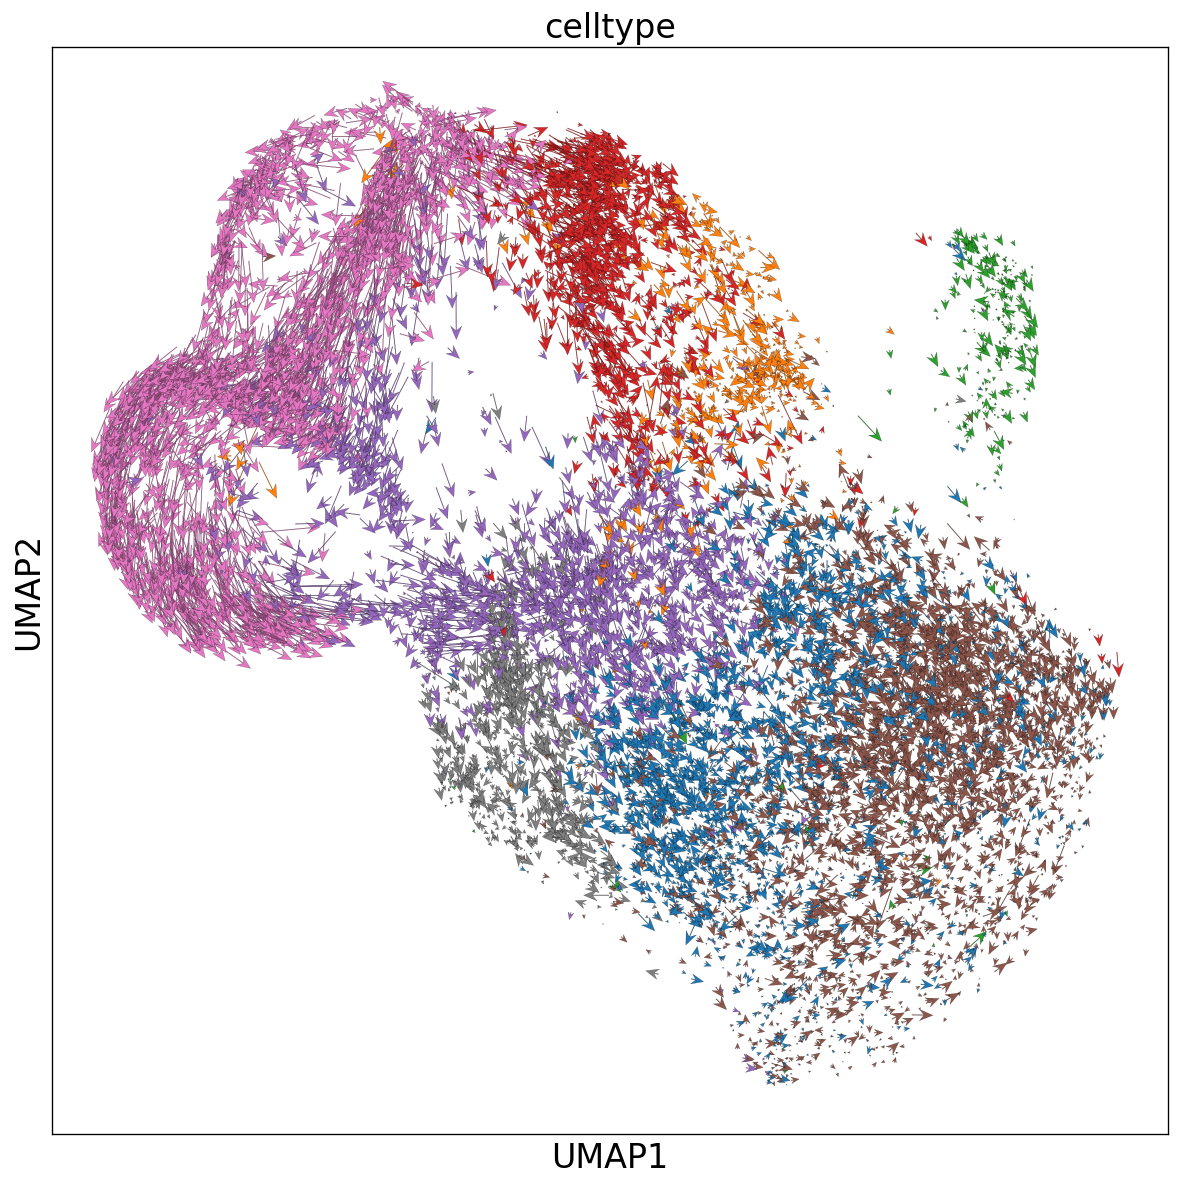

In [ ]:


scv.pl.velocity_embedding(merge_data, 
                          dpi=120, 
                          arrow_size=2, 
                          arrow_length=10, 
                          basis = "X_umap",
                          color="celltype",
                         figsize = (12, 12), 
                         fontsize=20, 
                         legend_fontsize=40, 
                         frameon=True)